## Lab 5, Group 1
### Names: Hailey DeMark, Deborah Park, Karis Park
### Student IDs: 48869449, 48878679, 48563429

Dataset: CDC Diabetes Health Indicators Link - https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset 

## Preparation (4 points total)
* [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# load dataset
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [3]:
numeric_cols = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"]
outcome = "Diabetes_binary"
categorical_cols = [ col for col in df.columns if col != outcome and col not in numeric_cols ]

df[categorical_cols] = df[categorical_cols].astype(int).astype(str)
df[outcome] = df[outcome].astype(int)

df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5.0,18.0,15.0,1,0,9.0,4.0,3.0
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3.0,0.0,0.0,0,0,7.0,6.0,1.0
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5.0,30.0,30.0,1,0,9.0,4.0,8.0
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2.0,0.0,0.0,0,0,11.0,3.0,6.0
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2.0,3.0,0.0,0,0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45.0,0,0,0,0,1,...,1,0,3.0,0.0,5.0,0,1,5.0,6.0,7.0
253676,1,1,1,1,18.0,0,0,0,0,0,...,1,0,4.0,0.0,0.0,1,0,11.0,2.0,4.0
253677,0,0,0,1,28.0,0,0,0,1,1,...,1,0,1.0,0.0,0.0,0,0,2.0,5.0,2.0
253678,0,1,0,1,23.0,0,0,0,0,1,...,1,0,3.0,0.0,0.0,0,1,7.0,5.0,1.0


Our dataset is on diabetes health indicators from the 2015 Behavioral Risk Factor Surveillance System (BRFSS), which includes 253,680 rows and 22 columns representing various health indicators. We didn't remove any of the variables in our dataset because each variable contains relevant health behavior or demographic data that may impact diabetes likelihood. We cast the variable Diabetes_binary to an integer type so it would be compatible with the classification tasks below. In our dataset, the only vairable that was continuous was BMI, so we initially just set this to the numeric column. However, after testing our model, we realized our model was not handling our ordinal variables properly. Even though our ordinal variables are categorical, their order matters, so we included GenHlth, MentHlth, PhysHlth, Age, Education, and Income as numerical features. The rest of our variables were set to categorical variables (there are 15), where we first converted them to integer format and then cast them to strings for compatibility with embedding layers later while modeling. 

* [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or why some features should not be crossed).


cross features 
- high BP 
- high cholesterol 
____ 

- stroke 
- deartdiseaseorAttack
____ 
- smoker 
- hvyAlcoholConsump


We decided to group high blood pressure and high cholesterol into cross-product features because both of these factors are commonly associated with cardiovascular and metabolic health issues. While we are noto certain that their interaction directly impacts diabetes risk, they often occur together in individuals with chronic conditions. This cross-product feature allows the model to learn whether their occurence together has a more predictive value than the variables alone. 

We grouped stroke and heart disease or heart attack together because these are two serious cardiovascular events that can indicate underlying health complications relevant to diabetes. Crossing these two variables may help the model detect a higher-risk subgroup or pattern related to long-term health outcomes. 

We also grouped smokers and heavy alcohol consumption together since these are both lifestyle factors that can negatively impact overall health. We suspect these behaviors are often found together in certain populations. We believe that combining these two variables may help find behavioral patterns that could relate to poor health management or incresed risk factors. 

* [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For this classification, we used recall to evaluate the metric. Recall measures the proportion of actual positive cases (people with diabetes) that the model correctly identifies. We believe this metric is the best for our dataset because false negatuves (cases where a person has diabetes but the model predicts they do not) are the most serious outcome and it has real-world consequences. Failing to detect diabetes in a patient could result in delayed treatement, undiagnosed complications, and long-term damage to a patient's health, or even more serious outcomes. It is more critical to minimize false negatives than false positives because even though a false positive may lead to further testing or inconvenience, a false negative could mean a missed opportunity to intervene. Optimizing for recall ensures that we are prioritizing the correct identification of individuals who are at risk and may need medical attention, even if it means accepting a slightly higher rate or false positives. 

* [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. Use the method to split your data that you argue for. 

We chose to use a single train/test split with an 80/20 ratio, where 80% of the data is used for training and 20% is used for testing. We applied stratification on the target variable (Diabetes_binary) so that the distribution of positive and negative cases remains consistent across both the training and test sets. This helps prevent a data imbalance in the training and testing groups. This is important so that diabetes prevalance in the population isn't skewed. We decided to use this splitting method rather than cross validation techniques due to how large our dataset is, since it contains over 250,000 rows. While cross-validation can be useful for smaller datasets to improve generalization estimates, it could complicate the results of our model since we have a massive and diverse dataset. 

#### Re split data if required for this step

In [4]:
X = copy.deepcopy(df)
y = X.pop(outcome).values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=1234, stratify = y)

## Modeling (5 points total)
* [2 points] Create at least three combined wide and deep networks to classify your data using Keras (this total of "three" includes the model you will train in the next step of the rubric). Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations.
    * Note: you can use the "history" return parameter that is part of Keras "fit" function to easily access this data.



In [5]:
# need to redefine the tf dataset to include cataegorical variables
# create a tensorflow dataset, for ease of use later
batch_size = 64

def create_dataset_from_dataframe(X, y):

    # get numeric feature data to start with, with categorical_headers
    df = {key: value.values[:,np.newaxis] for key, value in X[numeric_cols+categorical_cols].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), y))
    
    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

ds_train = create_dataset_from_dataframe(X_train, y_train)
ds_test = create_dataset_from_dataframe(X_test, y_test)

In [6]:
features = {}
for col in categorical_cols:
  features[col] = FeatureSpace.string_categorical(num_oov_indices=0)
for col in numeric_cols:
  features[col] = FeatureSpace.float_normalized()

feature_space = FeatureSpace(
    features=features,
    crosses=[
        FeatureSpace.cross(
          feature_names=('HighBP', 'HighChol'),
          crossing_dim=2*2
        ),
        FeatureSpace.cross(
          feature_names=('Stroke', 'HeartDiseaseorAttack'),
          crossing_dim=2*2
        ),
        FeatureSpace.cross(
          feature_names=('Smoker', 'HvyAlcoholConsump'),
          crossing_dim=2*2
        ),
    ],
    output_mode="concat",
)


feature_space.adapt(ds_train.map(lambda x, _: x))

2025-04-12 21:38:30.231827: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 21:38:31.065938: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 21:38:32.738819: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 21:38:36.053450: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 21:38:43.518994: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

# plotting model results 
def plot_loss(history):
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

    plt.show()

# stop adding epochs after accuracy isn't performing 0.05 better  
early_stopping = EarlyStopping(
    monitor = "loss",
    verbose = 1,
    patience = 5,
    mode = "min",
    min_delta = 0.05
)

### Model 1

In [16]:
def build_model(deep_neurons = [], final_neurons = []):
  dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

  # we need to create separate lists for each branch
  crossed_outputs = []

  # for each crossed variable, make an embedding
  for col in feature_space.crossers.keys():
      
      x = setup_embedding_from_crossing(feature_space, col)
      
      # save these outputs in list to concatenate later
      crossed_outputs.append(x)
      

  # now concatenate the outputs and add a fully connected layer
  wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

  # reset this input branch
  all_deep_branch_outputs = []

  # for each numeric variable, just add it in after embedding
  for idx,col in enumerate(numeric_cols):
      x = feature_space.preprocessors[col].output
      #x = tf.cast(x,float) # cast an integer as a float here
      all_deep_branch_outputs.append(x)
      
  # for each categorical variable
  for col in categorical_cols:
      
      # get the output tensor from ebedding layer
      x = setup_embedding_from_categorical(feature_space, col)
      
      # save these outputs in list to concatenate later
      all_deep_branch_outputs.append(x)


  # merge the deep branches together
  deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
  for i, neurons in enumerate(deep_neurons):
      deep_branch = Dense(units=neurons,activation='relu', name=f'deep{i}')(deep_branch)
      
  # merge the deep and wide branch
  final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
  for i, neurons in enumerate(final_neurons):
      final_branch = Dense(units=neurons,activation='relu', name=f'final{i}')(final_branch)
  final_branch = Dense(units=1,activation='sigmoid',
                      name='combined')(final_branch)

  model = keras.Model(inputs=dict_inputs, outputs=final_branch)
  model.compile(
      optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
  )

  print(model.summary())

  return model

In [17]:
model1 = build_model([50, 25, 10], [])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HighChol            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CholCheck           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Smoker (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stroke (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HeartDiseaseorAtta… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhysActivity        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fruits (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Veggies             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HvyAlcoholConsump   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AnyHealthcare       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NoDocbcCost         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DiffWalk            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sex (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighBP[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighChol[0][0]    │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ CholCheck[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ Smoker[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,725 (10.67 KB)

 Trainable params: 2,704 (10.56 KB)

 Non-trainable params: 21 (112.00 B)

None


In [18]:
history1 = model1.fit(
    ds_train, epochs=100, validation_data=ds_test, callbacks=[early_stopping]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'Age': 'Age', 'AnyHealthcare': 'AnyHealthcare', 'BMI': 'BMI', 'CholCheck': 'CholCheck', 'DiffWalk': 'DiffWalk', 'Education': 'Education', 'Fruits': 'Fruits', 'GenHlth': 'GenHlth', 'HeartDiseaseorAttack': 'HeartDiseaseorAttack', 'HighBP': 'HighBP', 'HighChol': 'HighChol', 'HvyAlcoholConsump': 'HvyAlcoholConsump', 'Income': 'Income', 'MentHlth': 'MentHlth', 'NoDocbcCost': 'NoDocbcCost', 'PhysActivity': 'PhysActivity', 'PhysHlth': 'PhysHlth', 'Sex': 'Sex', 'Smoker': 'Smoker', 'Stroke': 'Stroke', 'Veggies': 'Veggies'}
Received: inputs={'BMI': 'Tensor(shape=(None, 1))', 'GenHlth': 'Tensor(shape=(None, 1))', 'MentHlth': 'Tensor(shape=(None, 1))', 'PhysHlth': 'Tensor(shape=(None, 1))', 'Age': 'Tensor(shape=(None, 1))', 'Education': 'Tensor(shape=(None, 1))', 'Income': 'Tensor(shape=(None, 1))', 'HighBP': 'Tensor(shape=(None, 1)

3171/3171 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8637 - loss: 0.3327 - val_accuracy: 0.8642 - val_loss: 0.3158
Epoch 2/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8662 - loss: 0.3135 - val_accuracy: 0.8646 - val_loss: 0.3152
Epoch 3/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8667 - loss: 0.3127 - val_accuracy: 0.8648 - val_loss: 0.3147
Epoch 4/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8671 - loss: 0.3121 - val_accuracy: 0.8650 - val_loss: 0.3145
Epoch 5/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8672 - loss: 0.3117 - val_accuracy: 0.8650 - val_loss: 0.3144
Epoch 6/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8672 - loss: 0.3113 - val_accuracy: 0.8653 - val_loss: 0.3142
Epoch 6: early stopping


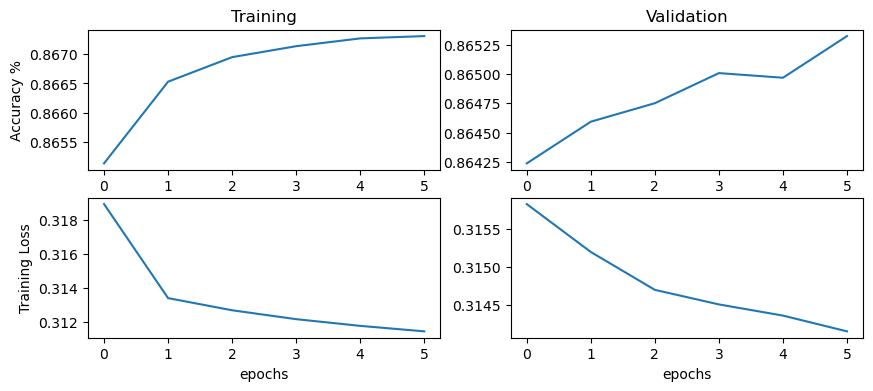

In [19]:
plot_loss(history1)

In [20]:
model2 = build_model([32, 16], [10])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HighChol            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CholCheck           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Smoker (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stroke (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HeartDiseaseorAtta… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhysActivity        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fruits (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Veggies             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HvyAlcoholConsump   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AnyHealthcare       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NoDocbcCost         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DiffWalk            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sex (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighBP[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighChol[0][0]    │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ CholCheck[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ Smoker[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,546 (6.07 KB)

 Trainable params: 1,525 (5.96 KB)

 Non-trainable params: 21 (112.00 B)

None


In [21]:
history2 = model2.fit(
    ds_train, epochs=100, validation_data=ds_test, callbacks=[early_stopping]
)

Epoch 1/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8611 - loss: 0.3405 - val_accuracy: 0.8640 - val_loss: 0.3151
Epoch 2/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8659 - loss: 0.3135 - val_accuracy: 0.8648 - val_loss: 0.3148
Epoch 3/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8666 - loss: 0.3128 - val_accuracy: 0.8650 - val_loss: 0.3144
Epoch 4/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8671 - loss: 0.3123 - val_accuracy: 0.8655 - val_loss: 0.3142
Epoch 5/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8672 - loss: 0.3120 - val_accuracy: 0.8653 - val_loss: 0.3141
Epoch 6/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8674 - loss: 0.3117 - val_accuracy: 0.8655 - val_loss: 0.3139
Epoch 6: early stopping


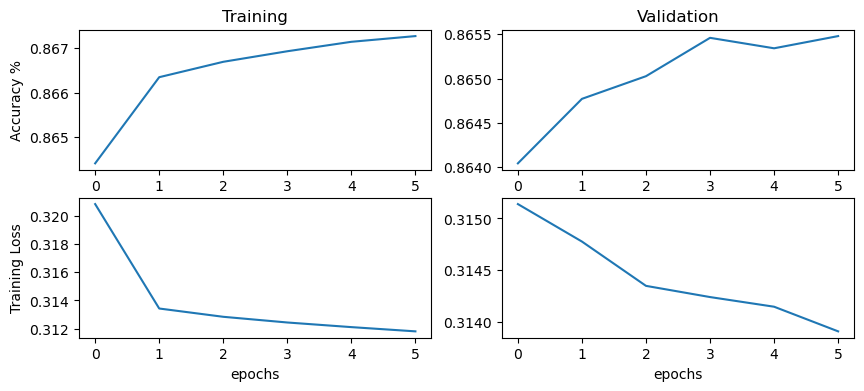

In [22]:
plot_loss(history2)

In [23]:
model3 = build_model([64, 32, 16], [20, 10])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HighChol            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CholCheck           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Smoker (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stroke (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HeartDiseaseorAtta… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhysActivity        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fruits (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Veggies             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HvyAlcoholConsump   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AnyHealthcare       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NoDocbcCost         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DiffWalk            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sex (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighBP[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ HighChol[0][0]    │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ CholCheck[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_categorical… │ (None, 1)         │          0 │ Smoker[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,770 (18.66 KB)

 Trainable params: 4,749 (18.55 KB)

 Non-trainable params: 21 (112.00 B)

None


In [24]:
history3 = model3.fit(
    ds_train, epochs=100, validation_data=ds_test, callbacks=[early_stopping]
)

Epoch 1/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8644 - loss: 0.3325 - val_accuracy: 0.8653 - val_loss: 0.3166
Epoch 2/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8665 - loss: 0.3135 - val_accuracy: 0.8651 - val_loss: 0.3161
Epoch 3/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8671 - loss: 0.3128 - val_accuracy: 0.8654 - val_loss: 0.3156
Epoch 4/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8675 - loss: 0.3123 - val_accuracy: 0.8654 - val_loss: 0.3156
Epoch 5/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8671 - loss: 0.3118 - val_accuracy: 0.8652 - val_loss: 0.3157
Epoch 6/100
3171/3171 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8674 - loss: 0.3114 - val_accuracy: 0.8656 - val_loss: 0.3155
Epoch 6: early stopping


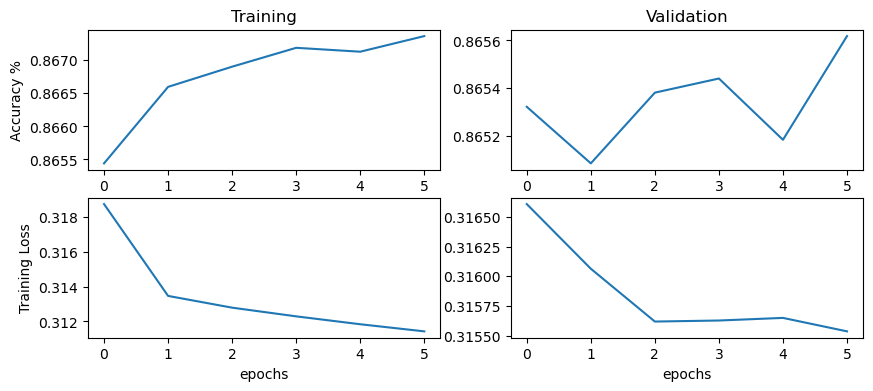

In [25]:
plot_loss(history3)

#### Plotting all 3 Models Together

In [26]:
def plot_all_models_metrics(h1, h2, h3):
    plt.figure(figsize=(14, 10))

    # Top left: Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(h1.history['accuracy'], label='Model 1')
    plt.plot(h2.history['accuracy'], label='Model 2')
    plt.plot(h3.history['accuracy'], label='Model 3')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Top right: Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(h1.history['val_accuracy'], label='Model 1')
    plt.plot(h2.history['val_accuracy'], label='Model 2')
    plt.plot(h3.history['val_accuracy'], label='Model 3')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Bottom left: Training Loss
    plt.subplot(2, 2, 3)
    plt.plot(h1.history['loss'], label='Model 1')
    plt.plot(h2.history['loss'], label='Model 2')
    plt.plot(h3.history['loss'], label='Model 3')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Bottom right: Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(h1.history['val_loss'], label='Model 1')
    plt.plot(h2.history['val_loss'], label='Model 2')
    plt.plot(h3.history['val_loss'], label='Model 3')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

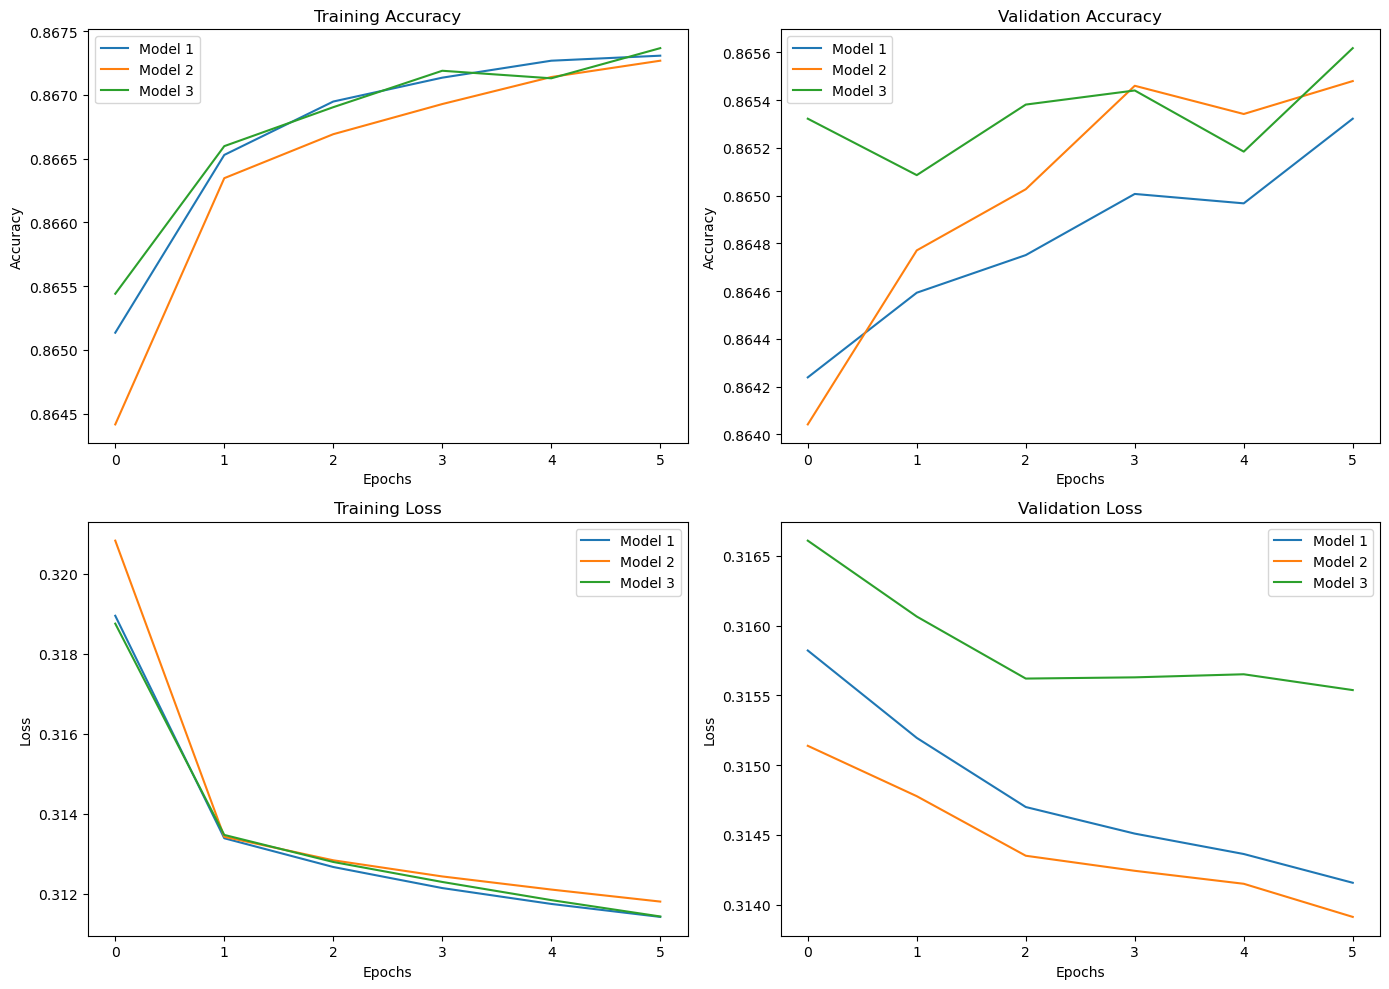

In [27]:
plot_all_models_metrics(history1, history2, history3)

* [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two models (this "two" includes the wide and deep model trained from the previous step). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to answer: What model with what number of layers performs superiorly? Use proper statistical methods to compare the performance of different models.

* [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  

## Exceptional Work (1 points total)